In [1]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank as localPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx
from matplotlib import cm
from matplotlib.colors import rgb2hex

In [2]:
# load the Facebook dataset
A, N, D = edgelistParser("datasets/facebook/107.edges", "raw_list")

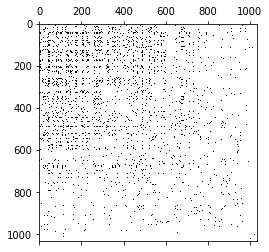

In [3]:
# convert the edge list to a dense matrix
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

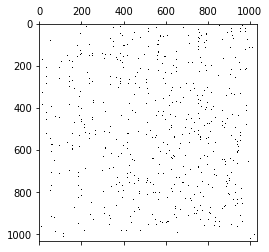

In [4]:
# generate the L matrix
L = localPageRank(A, c=0.85, return_only_neighbours=True)
L_mat = list2matrix(L)
plt.figure()
plt.spy(L_mat)
plt.show()

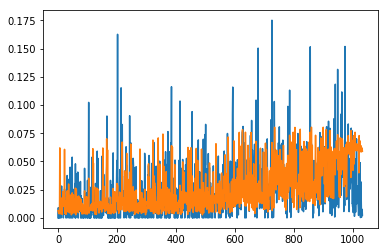

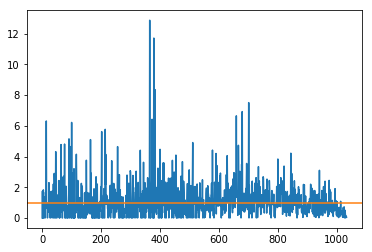

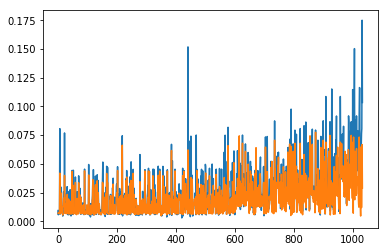

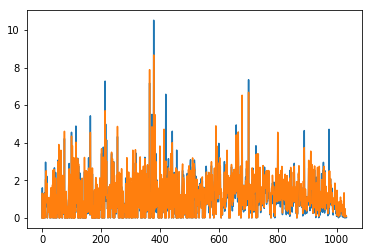

In [5]:
# get in/out degrees
inDeg, outDeg = getInOutDegree(L)
# compute the ratio in/out
ratio = np.array(inDeg)
ratio[np.array(outDeg)==0] = 0
ratio[np.array(outDeg)!=0] /= np.array(outDeg)[np.array(outDeg)!=0]
# compute the thresholded ratio
ratio_th = ratio.copy()
th = 1
ratio_th[ratio_th>th] = th
# compute the average neighbours degrees
avgNeighInDeg = [0.]*len(A)
avgNeighOutDeg = [0.]*len(A)
for i, n in enumerate(A):
    for e in n:
        avgNeighInDeg[i] += inDeg[e[0]]
        avgNeighOutDeg[i] += outDeg[e[0]]
    if len(n) > 0:
        avgNeighInDeg[i] /= len(n)
        avgNeighOutDeg[i] /= len(n)
# compute ratio between in deg and average neighs in deg
ratio1 = np.array(inDeg)
ratio1[np.array(avgNeighInDeg)==0] = 0
ratio1[np.array(avgNeighInDeg)!=0] /= np.array(avgNeighInDeg)[np.array(avgNeighInDeg)!=0]
# do the same for the average neighs out deg
ratio2 = np.array(inDeg)
ratio2[np.array(avgNeighOutDeg)==0] = 0
ratio2[np.array(avgNeighOutDeg)!=0] /= np.array(avgNeighOutDeg)[np.array(avgNeighOutDeg)!=0]

# plot the results
fig, ax = plt.subplots(1, 1)
ax.plot(inDeg)
ax.plot(outDeg)
fig, ax = plt.subplots(1, 1)
ax.plot(ratio)
xl = ax.get_xlim()
ax.plot(xl, [th, th])
_ = ax.set_xlim(xl)
fig, ax = plt.subplots(1, 1)
ax.plot(avgNeighInDeg)
ax.plot(avgNeighOutDeg)
fig, ax = plt.subplots(1, 1)
ax.plot(ratio1)
ax.plot(ratio2)

In [6]:
def plotNetwork(A_mat, A, colors, pos=None):
    # test the network plot
    G = nx.from_numpy_matrix(A_mat)

    plt.figure(num=None, figsize=(15, 10), facecolor='w', edgecolor='k')
    
    if pos is None:
        pos = nx.spring_layout(G)
    for n in range(len(A)):
        nx.draw_networkx_nodes(G, pos, [n], 5, node_color = rgb2hex(colors[n][:3]))

    nx.draw_networkx_edges(G, pos, alpha=0.1)

    plt.show()
    
    return pos

In [7]:
x = np.array(inDeg)/np.array(inDeg).max()
colors_inDeg = cm.get_cmap('viridis')(x)
x = np.array(outDeg)/np.array(outDeg).max()
colors_outDeg = cm.get_cmap('viridis')(x)
x = ratio/ratio.max()
colors_ratio = cm.get_cmap('viridis')(x)
x = ratio_th/ratio_th.max()
colors_ratio_th = cm.get_cmap('viridis')(x)
x = np.array(avgNeighInDeg)/np.array(avgNeighInDeg).max()
colors_neigInDeg = cm.get_cmap('viridis')(x)
x = np.array(avgNeighOutDeg)/np.array(avgNeighOutDeg).max()
colors_neigOutDeg = cm.get_cmap('viridis')(x)
x = ratio1/ratio1.max()
colors_ratio1 = cm.get_cmap('viridis')(x)
x = ratio2/ratio2.max()
colors_ratio2 = cm.get_cmap('viridis')(x)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


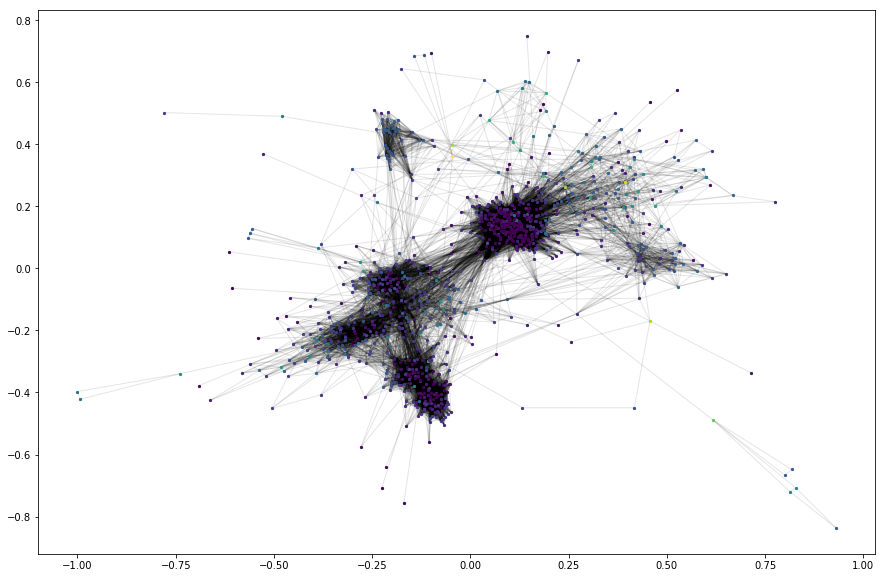

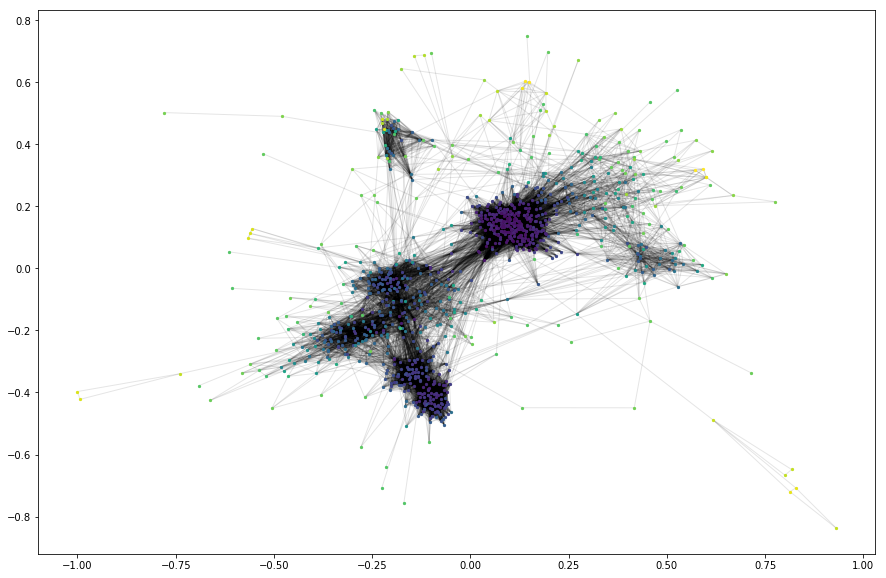

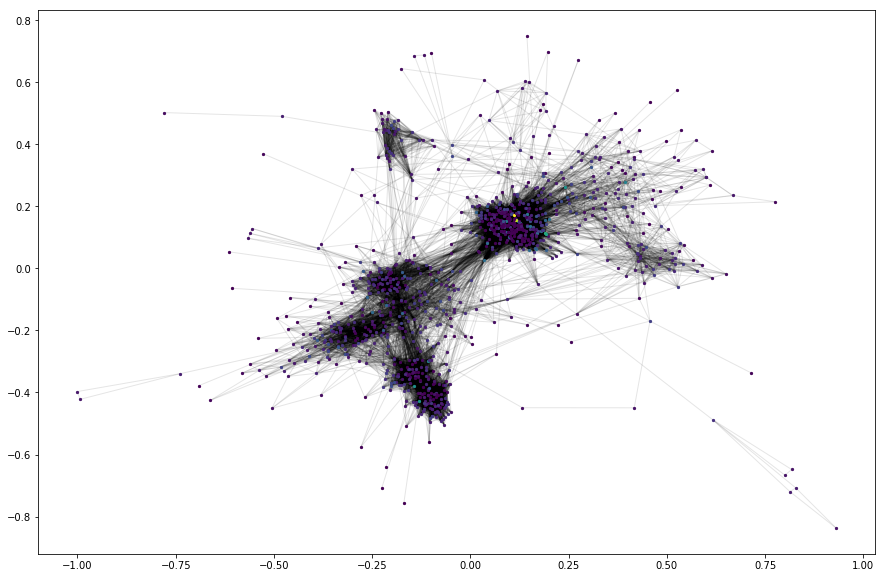

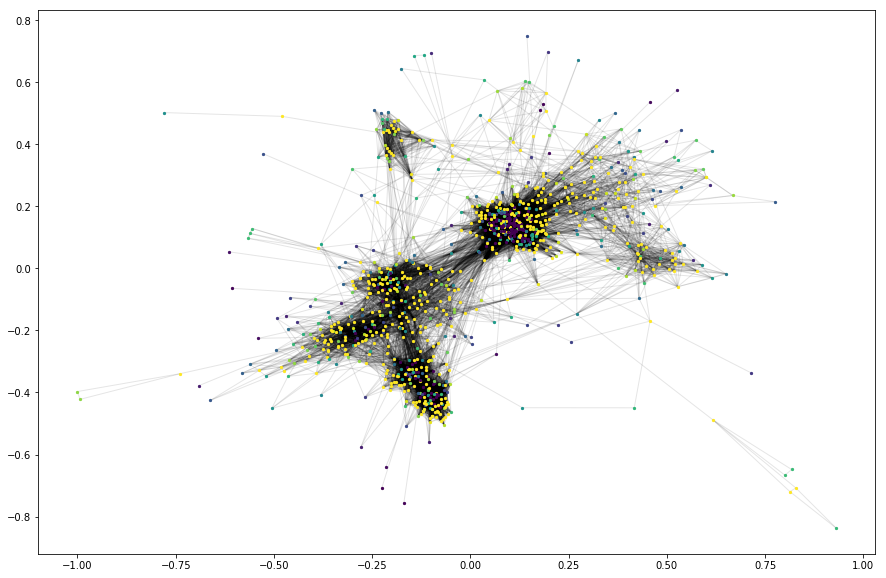

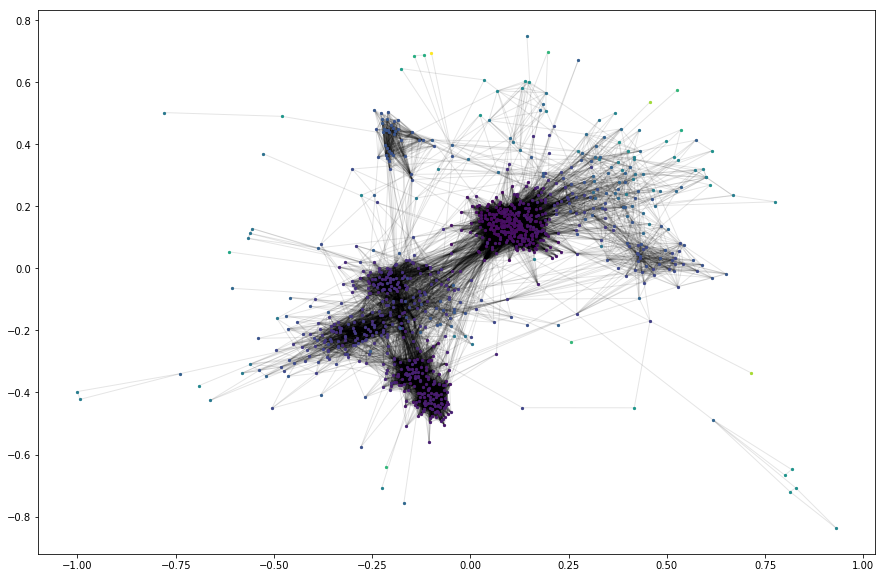

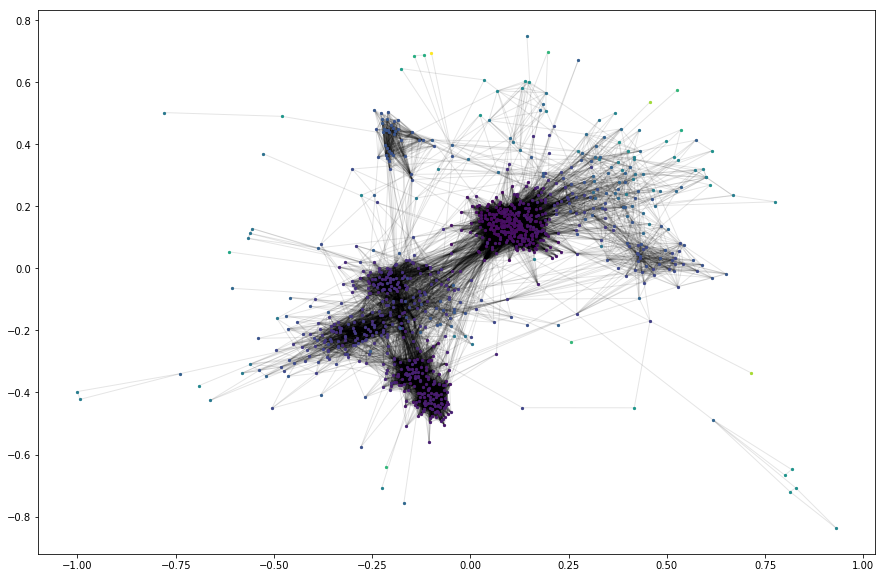

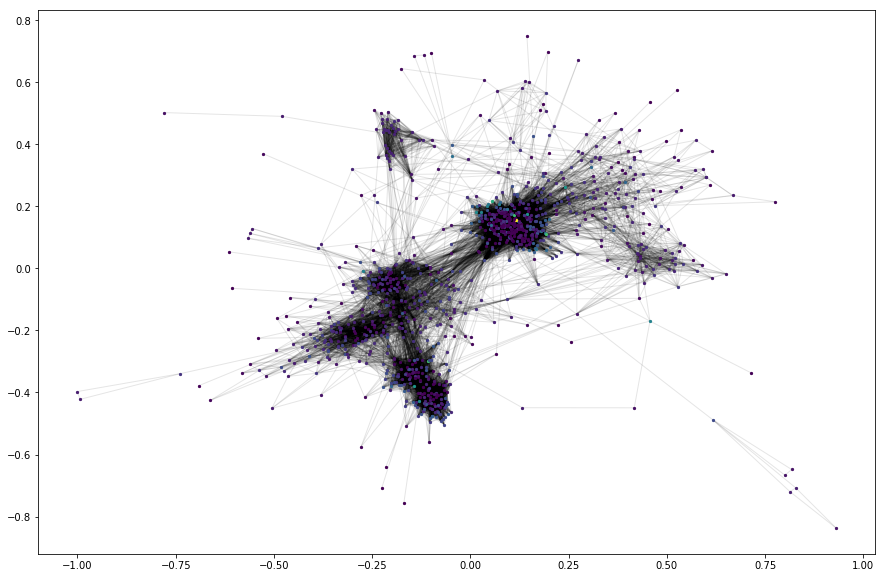

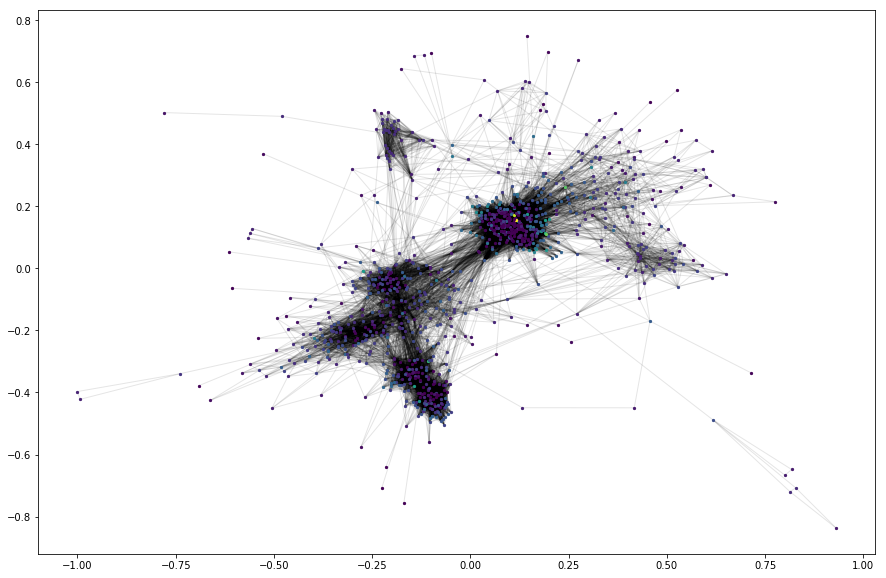

In [8]:
pos = plotNetwork(A_mat, A, colors_inDeg)
plotNetwork(A_mat, A, colors_outDeg, pos)
plotNetwork(A_mat, A, colors_ratio, pos)
plotNetwork(A_mat, A, colors_ratio_th, pos)
plotNetwork(A_mat, A, colors_neigInDeg, pos)
plotNetwork(A_mat, A, colors_neigInDeg, pos)
plotNetwork(A_mat, A, colors_ratio1, pos)
_ = plotNetwork(A_mat, A, colors_ratio2, pos)

In [9]:
def getTopKnonNeighs(rank, th, A):
    cut_idx = np.where(rank>=th)[0]
    idxs = list(np.argsort(rank[rank>th])[::-1])
    curr_id = 0
    while curr_id < len(idxs):
        # remove the neighbours of the current node
        for e in A[idxs[curr_id]]:
            if e[0] in idxs:
                idxs.remove(e[0])
            # remove also the neighbours of the neighbour
            for ne in A[e[0]]:
                if ne[0] in idxs and ne[0] != idxs[curr_id]:
                    idxs.remove(ne[0])
        
        curr_id += 1
        
    return list(cut_idx[idxs])

In [10]:
topk = getTopKnonNeighs(ratio2, -1, A)
print(topk)

[379, 373, 414, 726, 856, 455, 104, 974, 949, 803, 805, 981, 786, 653, 672, 322, 985, 992, 897, 975, 388, 944, 1018, 998, 152, 1014, 1007, 920, 1029, 929]
